# Code for generating SFig 4 from derivative data

#### Raw code for generating derivative data is in 
`analysis1_compute_regional_RDMs.py --randomtasks $k --randomtaskID $i`, where k is the number of subsampled tasks, and i is a random id number

In [1]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r
from brainsmash.mapgen.stats import nonparp

#### Set up basic parameters

In [2]:
figuredir = '../figures/SFig4/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']
sensorynets = ['vis1','vis2','aud']
motornets = ['smn']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])

boxpalette = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2]]
    
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 

# Load multi-task representational dimensionality and margulies gradients

In [3]:
df_dim = pd.read_csv('../processed_data/analysis1/analysis1_parcel_cosine_dimensionality.csv')
avg_dim = []
for i in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    avg_dim.append(df_dim.Dimensionality[df_dim.Parcels==i+1].mean())
avg_dim = np.asarray(avg_dim)

In [5]:
niterations = 20
rsm_matrix = 'cosine'
df_dim = pd.DataFrame()
avg_dims = {}
for tasksize in [2, 5, 10, 20, 30, 40]:
    for i in range(1,niterations+1):
        tmpdf = pd.read_csv('../processed_data/analysis1/analysis1_parcel_' + rsm_matrix + '_dimensionality_randomtasks' + str(tasksize) + '_ID' + str(i) + '.csv')
        tmpdf.insert(loc=0,column='Iteration', value=np.repeat(i,len(tmpdf)))
        tmpdf.insert(loc=0,column='Task size', value=np.repeat(tasksize,len(tmpdf)))
        df_dim = df_dim.append(tmpdf)
avg_dims_df = df_dim.groupby(['Task size','Parcels','Iteration']).mean()
avg_dims_df = avg_dims_df.reset_index()


# Plot dimensionality versus RSFC Grad 1

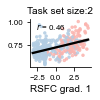

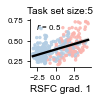

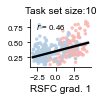

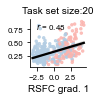

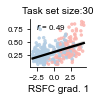

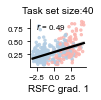

In [6]:
parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')

tmpdf = avg_dims_df.groupby(['Task size','Parcels']).mean().reset_index()
for tasksize in tmpdf['Task size'].unique():
    tmpdim = tmpdf.loc[tmpdf['Task size']==tasksize]
    tmpdim2 = tmpdim.Dimensionality.values
    plt.figure(figsize=(1.4,1.5))
    sns.regplot(x=parcellated_gradients[:,0],y=tmpdim2,color='k',order=1,scatter_kws={'s':6,'color':roiColorsByNetwork})
    plt.xlabel('RSFC grad. 1',fontsize=10)
    plt.title('Task set size:' + str(tasksize),fontsize=10)
    plt.xticks(fontsize=8)
    rho, p = stats.pearsonr(parcellated_gradients[:,0],tmpdim2)
    rho = round(rho,2)
    p = round(p,2)
    plt.annotate(r'$r$'+ ' = ' + str(rho),
                 xy=(0.1,.8),fontsize=8,xycoords='axes fraction')
    plt.yticks(fontsize=8)
    sns.despine()
    plt.tight_layout()

# Full task set

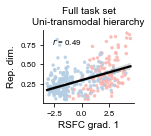

In [7]:
plt.figure(figsize=(2,2))
sns.regplot(x=parcellated_gradients[:,0],y=avg_dim,color='k',order=1,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RSFC grad. 1',fontsize=10)
plt.title('Full task set\nUni-transmodal hierarchy',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Rep. dim.',fontsize=10)
rho, p = stats.pearsonr(parcellated_gradients[:,0],tmpdim2)
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.1,.8),fontsize=8,xycoords='axes fraction')
plt.xlim([-3.5,4.75])

plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'Dim_X_RSGradient1.pdf',transparent=True)

# Correlate dimensionality of different task set sizes 

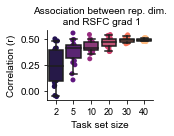

In [8]:
corr_with_fcgrad = {}
corr_with_fcgrad['Task size'] = []
corr_with_fcgrad['Iteration'] = []
corr_with_fcgrad['Correlation'] = []
parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')
for tasksize in avg_dims_df['Task size'].unique():
    for i in range(1,niterations+1):
        tmpdf = avg_dims_df.loc[(avg_dims_df['Task size']==tasksize) & (avg_dims_df['Iteration']==i)]
        avg_dim = tmpdf.Dimensionality.values
        r, p = stats.pearsonr(parcellated_gradients[:,0],avg_dim)
        corr_with_fcgrad['Task size'].append(tasksize)
        corr_with_fcgrad['Iteration'].append(i)
        corr_with_fcgrad['Correlation'].append(r)
        
corr_with_fcgrad = pd.DataFrame(corr_with_fcgrad)
plt.figure(figsize=(2.25,2))
ax = sns.boxplot(x="Task size",y="Correlation",data=corr_with_fcgrad,palette='magma',sym='',whis=[2.5,97.5])
sns.stripplot(x="Task size",y="Correlation",data=corr_with_fcgrad,palette='magma',zorder=0)
plt.xticks(fontsize=9);
plt.xlabel('Task set size',fontsize=10);
plt.ylabel('Correlation (r)',fontsize=10);
plt.title('Association between rep. dim.\n and RSFC grad 1', fontsize=10);
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RepDimXRSFC1_TaskSubsets.pdf',dpi=300)
    

# correlation with myelin map

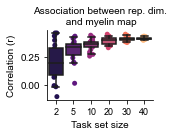

In [11]:
corr_with_fcgrad = {}
corr_with_fcgrad['Task size'] = []
corr_with_fcgrad['Iteration'] = []
corr_with_fcgrad['Correlation'] = []
myelin_map_64k = np.loadtxt('../processed_data/MyelinMapParcellated_v1.csv',delimiter=',')
myelin_map = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    myelin_map[roi] = np.mean(myelin_map_64k[roi_ind])

for tasksize in avg_dims_df['Task size'].unique():
    for i in range(1,niterations+1):
        tmpdf = avg_dims_df.loc[(avg_dims_df['Task size']==tasksize) & (avg_dims_df['Iteration']==i)]
        avg_dim = tmpdf.Dimensionality.values
        r, p = stats.pearsonr(myelin_map,avg_dim)
        corr_with_fcgrad['Task size'].append(tasksize)
        corr_with_fcgrad['Iteration'].append(i)
        corr_with_fcgrad['Correlation'].append(r)
        
corr_with_fcgrad = pd.DataFrame(corr_with_fcgrad)
plt.figure(figsize=(2.25,2))
ax = sns.boxplot(x="Task size",y="Correlation",data=corr_with_fcgrad,palette='magma',sym='',whis=[2.5,97.5])
sns.stripplot(x="Task size",y="Correlation",data=corr_with_fcgrad,palette='magma',zorder=0)
plt.xticks(fontsize=9);
plt.xlabel('Task set size',fontsize=10);
plt.ylabel('Correlation (r)',fontsize=10);
plt.title('Association between rep. dim.\n and myelin map', fontsize=10);
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RepDimXMyelinMap_TaskSubsets.pdf',dpi=300)    

# Plot task set dimensionality versus IO gradient

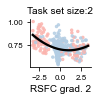

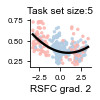

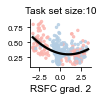

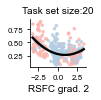

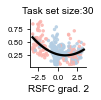

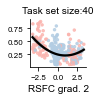

In [12]:
tmpdf = avg_dims_df.groupby(['Task size','Parcels']).mean().reset_index()
for tasksize in tmpdf['Task size'].unique():
    tmpdim = tmpdf.loc[tmpdf['Task size']==tasksize]
    tmpdim2 = tmpdim.Dimensionality.values
    plt.figure(figsize=(1.4,1.5))
    sns.regplot(x=parcellated_gradients[:,1],y=tmpdim2,color='k',order=2,scatter_kws={'s':6,'color':roiColorsByNetwork})
    plt.xlabel('RSFC grad. 2',fontsize=10)
    plt.title('Task set size:' + str(tasksize),fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    sns.despine()

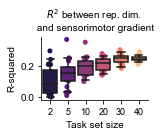

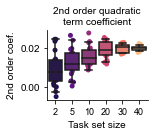

In [20]:
quad_with_IO = {}
quad_with_IO['Task size'] = []
quad_with_IO['Iteration'] = []
quad_with_IO['R-squared'] = []
quad_with_IO['X^2'] = []
parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')
for tasksize in avg_dims_df['Task size'].unique():
    for i in range(1,niterations+1):
        tmpdf = avg_dims_df.loc[(avg_dims_df['Task size']==tasksize) & (avg_dims_df['Iteration']==i)]
        avg_dim = tmpdf.Dimensionality.values
        
        polynomial_features = PolynomialFeatures(degree=2)
        x = parcellated_gradients[:,1].copy()
        x.shape = (len(x),1)
        xp2 = polynomial_features.fit_transform(x)

        y = avg_dim
        #fit regression model
        ra_model2 = sm.OLS(y, xp2).fit()

        
        r, p = stats.pearsonr(parcellated_gradients[:,1],avg_dim)
        quad_with_IO['Task size'].append(tasksize)
        quad_with_IO['Iteration'].append(i)
        quad_with_IO['R-squared'].append(ra_model2.rsquared)
        quad_with_IO['X^2'].append(ra_model2.params[2])
        
        
        
quad_with_IO = pd.DataFrame(quad_with_IO)
plt.figure(figsize=(2.25,2))
ax = sns.boxplot(x="Task size",y="R-squared",data=quad_with_IO,palette='magma',sym='',whis=[2.5,97.5])
sns.stripplot(x="Task size",y="R-squared",data=quad_with_IO,palette='magma',zorder=0)
plt.xticks(fontsize=9);
plt.xlabel('Task set size',fontsize=10);
plt.ylabel('R-squared',fontsize=10);
plt.title('$R^2$ between rep. dim.\n and sensorimotor gradient', fontsize=10);
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'Rsquared_RepDimXRSFC2_TaskSubsets.pdf',dpi=300)    

plt.figure(figsize=(2.25,2))
ax = sns.boxplot(x="Task size",y="X^2",data=quad_with_IO,palette='magma',sym='',whis=[2.5,97.5])
sns.stripplot(x="Task size",y="X^2",data=quad_with_IO,palette='magma',zorder=0)
plt.xticks(fontsize=9);
plt.xlabel('Task set size',fontsize=10);
plt.ylabel('2nd order coef.',fontsize=10);
plt.title('2nd order quadratic\nterm coefficient', fontsize=10);
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'Quadratic_RepDimXRSFC2_TaskSubsets.pdf',dpi=300)    

# Full set association

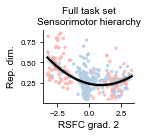

In [21]:
plt.figure(figsize=(2,2))
sns.regplot(x=parcellated_gradients[:,1],y=avg_dim,color='k',order=2,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RSFC grad. 2',fontsize=10)
plt.title('Full task set\nSensorimotor hierarchy',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Rep. dim.',fontsize=10)
plt.xlim([-3.6,3.5])
plt.tight_layout()
sns.despine()
# plt.savefig(figuredir + 'Dim_X_RSGradient2.pdf',transparent=True)